In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from collections import OrderedDict
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['arch'] == 'ResNet':
        model = models.vgg19(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
#     elif:
#         print("Sorry base architecture note recognized")
#         break 
    
    model.class_to_idx = chpt['class_to_idx']
    
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 128)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(128, 8)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [10]:
import torch
from torchvision import datasets, models, transforms
from PIL import Image
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

chpt = torch.load("models")
model = models.resnet50(pretrained=False).to(device)
# model.class_to_idx = chpt['class_to_idx']
# model.fc = nn.Sequential(
#                nn.Linear(2048, 128),
#                nn.ReLU(inplace=True),
#                nn.Linear(128, 8)).to(device)
model.fc = nn.Sequential(
                      nn.Linear(2048, 128),
                      nn.ReLU(),
                      nn.Linear(128, 8))
    
# model.load_state_dict(torch.load('models'))
# print(model)

PermissionError: [Errno 13] Permission denied: 'models'

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    im = Image.open(image)
    im = im.resize((256,256))
    value = 0.5*(256-224)
    im = im.crop((value,value,256-value,256-value))
    im = np.array(im)/255

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = (im - mean) / std

    return im.transpose(2,0,1)

In [24]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [25]:
def predict(image_path, model, topk=3):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    # move the model to cuda
    cuda = torch.cuda.is_available()
    if cuda:
        # Move model parameters to the GPU
        model.cuda()
        print("Number of GPUs:", torch.cuda.device_count())
        print("Device name:", torch.cuda.get_device_name(torch.cuda.device_count()-1))
    else:
        model.cpu()
        print("We go for CPU")
    
    # turn off dropout
    model.eval()

    # The image
    image = process_image(image_path)
    
    # tranfer to tensor
    image = torch.from_numpy(np.array([image])).float()
    
    # The image becomes the input
    image = Variable(image)
    if cuda:
        image = image.cuda()
        
    output = model.forward(image)
    
    probabilities = torch.exp(output).data
    
    # getting the topk (=5) probabilites and indexes
    # 0 -> probabilities
    # 1 -> index
    prob = torch.topk(probabilities, topk)[0].tolist()[0] # probabilities
    index = torch.topk(probabilities, topk)[1].tolist()[0] # index
    
    ind = []
    print(prob)
    for i in range(len(model.class_to_idx.items())):
        ind.append(list(model.class_to_idx.items())[i][0])

    # transfer index to label
    label = []
    for i in range(3):
        label.append(ind[index[i]])

    return prob, label

Number of GPUs: 1
Device name: GeForce RTX 2080 SUPER
[5147.0, 16.346904754638672, 1.5353437662124634]
[5147.0, 16.346904754638672, 1.5353437662124634]
['Karty Kredytowe', 'Dokumenty Tożsamości', 'Wykresy i Schematy']


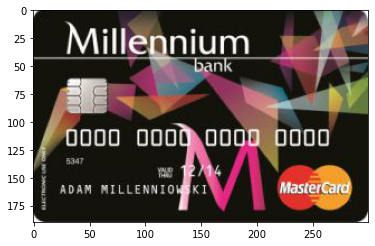

In [26]:
import os, random
img = random.choice(os.listdir('data/'))
img_path = 'data/' + img
with  Image.open(img_path) as image:
    plt.imshow(image)
    
prob, classes = predict(img_path, model)
print(prob)
print(classes)

